Deep learning methods for new sound generation
======
In this work, we transform audios into spectrograms and use CNN-based model to learn. This notebook is a guideline.
Firstly, we load all needed sources.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import tensorflow as tf
from keras import backend as K
! pip install ddsp
! pip install torchsynth
%cd /content/drive/MyDrive/Thesis_upload/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.0
    Uninstalling tensorboard-2.10.0:
      Successfully uninstalled tensorboard-2.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 1.7.5 requires tensorboard>=2.9.1, but you have tensorboard 2.8.0 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorboard-2.10.0-py3-none-any.whl (5.9 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


/content/drive/MyDrive/Thesis_upload


Dataset
======
The hybrid dataset consists of one online generated synthetic dataset and 3 external sources (e.g. Synthetic, ARTURIA, NSynth and SoundFonts).
You can use show_data to show spectrograms visually. (This method returns the objective dataset.)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/lightning.py:23: LightningDeprecationWarning: pytorch_lightning.core.lightning.LightningModule has been deprecated in v1.7 and will be removed in v1.9. Use the equivalent class from the pytorch_lightning.core.module.LightningModule class instead.
  "pytorch_lightning.core.lightning.LightningModule has been deprecated in v1.7"


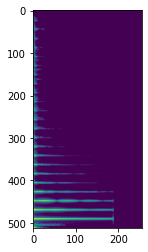

In [2]:
from load_data import show_data
test_data = show_data(dataset_name="NSynth", index=10) ## show the 10-th sample from the NSynth dataset
# test_data = show_data(dataset_name="Synthetic", n_sample=10) ## show 10 samples from the Synthetic dataset

Generation of new sounds
======
This section evaluates the trained model and uses it to generate new sounds.

In [3]:
from new_sound_generation import test_reconstruction, test_interpulation, test_random_sampling, test_style_transform
encoder = tf.keras.models.load_model(f"models/encoder_1.h5")
decoder = tf.keras.models.load_model(f"models/decoder_1.h5")
# encoder = tf.keras.models.load_model(f"models/new_trained_models/encoder.h5")
# decoder = tf.keras.models.load_model(f"models/new_trained_models/decoder.h5")
perceptual_label_predictor = tf.keras.models.load_model(f"models/perceptual_label_predictor.h5")

### Show reconstruction results

######################################################
index: 0
Original:


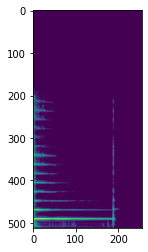

Reconstruction:


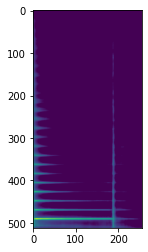

######################################################
index: 563
Original:


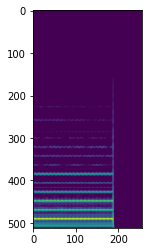

Reconstruction:


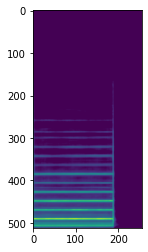

######################################################
index: 626
Original:


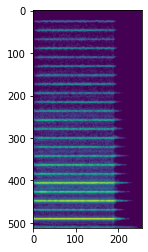

Reconstruction:


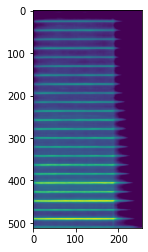

In [4]:
test_reconstruction(encoder, decoder, test_data, n_sample=3, f=0, path_name="./data/test_reconstruction", save_data=True)

### Generate new sounds by latent space interpolation.

First Original:


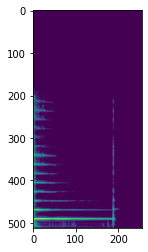

Second Original:


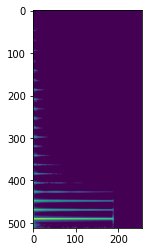

######################################################
Interpolations:


  0%|          | 0/9 [00:00<?, ?it/s]

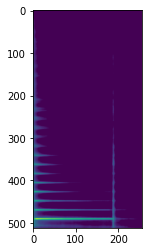

 11%|█         | 1/9 [00:00<00:04,  1.73it/s]

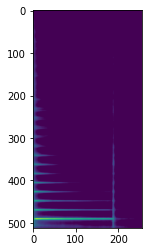

 22%|██▏       | 2/9 [00:01<00:04,  1.69it/s]

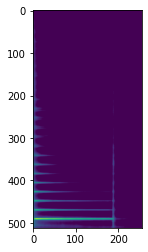

 33%|███▎      | 3/9 [00:01<00:03,  1.69it/s]

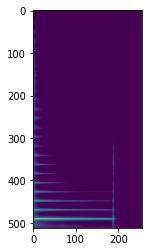

 44%|████▍     | 4/9 [00:02<00:02,  1.72it/s]

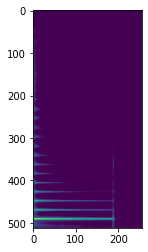

 56%|█████▌    | 5/9 [00:02<00:02,  1.76it/s]

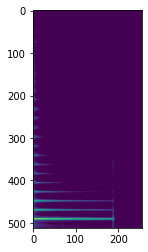

 67%|██████▋   | 6/9 [00:03<00:01,  1.75it/s]

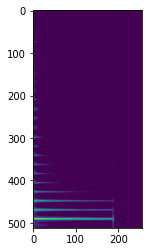

 78%|███████▊  | 7/9 [00:04<00:01,  1.77it/s]

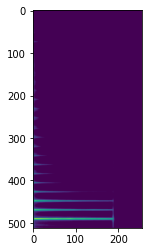

 89%|████████▉ | 8/9 [00:04<00:00,  1.78it/s]

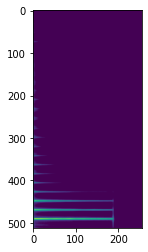

100%|██████████| 9/9 [00:05<00:00,  1.76it/s]


In [5]:
test_interpulation(test_data[0], test_data[1], encoder, decoder, path_name = "./data/test_interpolation", save_data=True)


### Generate new sounds by random sampling in the latent space.

  0%|          | 0/5 [00:00<?, ?it/s]

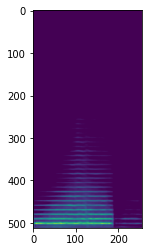

 20%|██        | 1/5 [00:00<00:02,  1.85it/s]

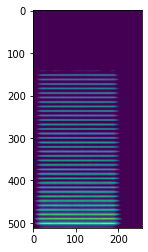

 40%|████      | 2/5 [00:01<00:01,  1.80it/s]

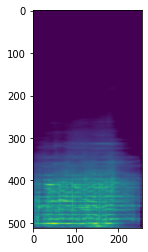

 60%|██████    | 3/5 [00:01<00:01,  1.78it/s]

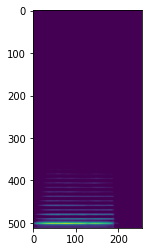

 80%|████████  | 4/5 [00:02<00:00,  1.76it/s]

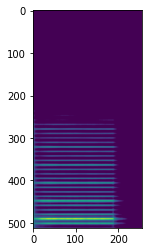

100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


In [6]:
test_random_sampling(decoder=decoder, n_sample=5, save_data=True, path_name = "./data/test_random_sampling")

### Generate new sounds by style transform.

Original:


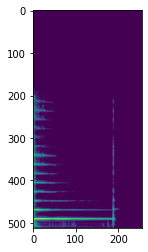

######################################################
Manipulated (suffix):


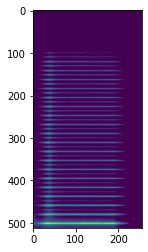

In [7]:
test_style_transform(test_data[0], encoder=encoder, decoder=decoder, perceptual_label_predictor=perceptual_label_predictor,
                     n_samples=100, save_data=True, goal=2, direction=1, path_name = "./data/test_style_transform")

The CNN-based VAE
======
The following code assembles and trains the CNN-based VAE.

Detailed implementation of components (e.g. Attention, Upsample, etc.) can be found in *VAE_model.py*.

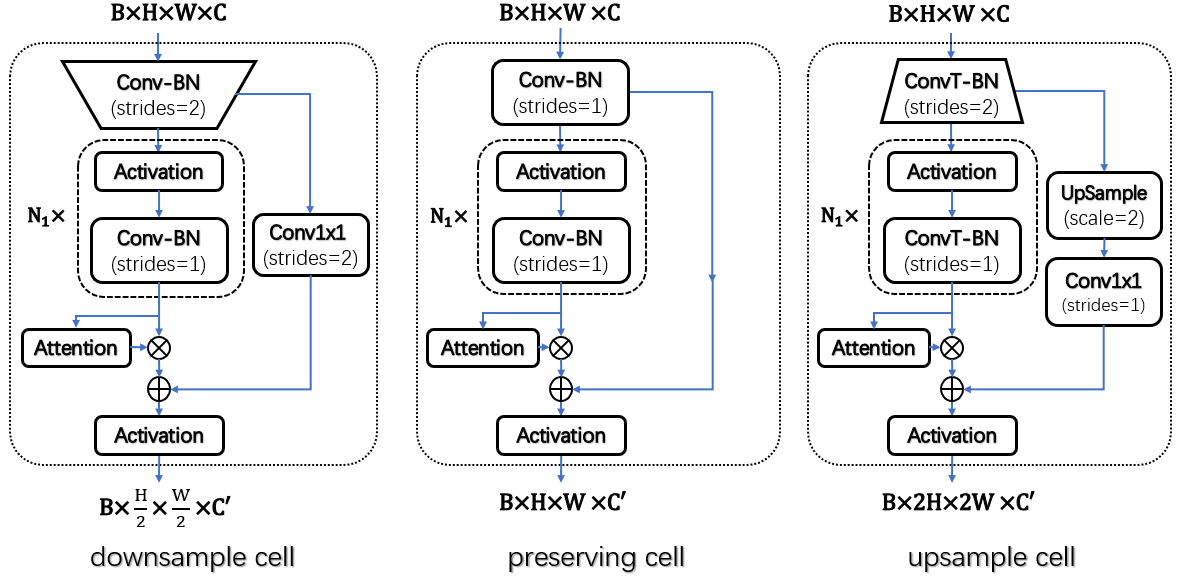

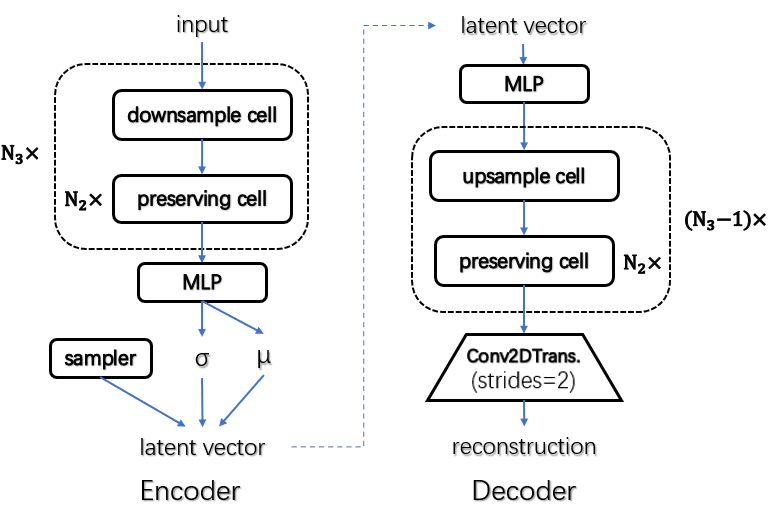

In [ ]:
from model.VAE import VAE, train_VAE
from load_data import load_data

# Generate models
encoder, decoder, vae = VAE(N2=0, N3=8, channel_sizes=[32,64,64,96,96,128,160,216])

# Define training stages
stages = []
for i in range(8):
  stages.append({"n_epoch": 50, "threshold": 1e-0, "kl_weight": 100.0, "learning_rate": 0.0001})
for i in range(4):
  stages.append({"n_epoch": 50, "threshold": 1e-2, "kl_weight": 500.0, "learning_rate": 0.00001})
for i in range(2):
  stages.append({"n_epoch": 50, "threshold": 1e-3, "kl_weight": 1000.0, "learning_rate": 0.00001})

# Generate data
data_cache = load_data(1500)

# Train the model (Models will be stored under directory "/models/new_trained_models")
train_VAE(vae, encoder, decoder, data_cache, stages, 16)

The perceptual label predictor
======
The following code assembles and trains the perceptual label predictor.

In [ ]:
from model.perceptual_label_predictor import perceptual_label_predictor, train_perceptual_label_predictor

# Generate the model
PLP = perceptual_label_predictor()

# Generate data and train the model (Model will be stored under directory "/models/new_trained_models")
train_perceptual_label_predictor(PLP, encoder)